# Access to ECMWF data

This notebook is a collection of functions and tools to access the necessary data used in TropiDash \
Access ECMWF Open Data: https://www.ecmwf.int/en/forecasts/datasets/open-data \
Forecasted variables can be accessed through `ecwmf.opendata`

## Setup

In [2]:
import datetime
import eccodes
from ecmwf.opendata import Client
import os
import numpy as np
import pandas as pd
import pdbufr
import pygrib
import requests
import rioxarray as rxr
import xarray as xr

The user will select the timestep from the widget, so date/time and step needed to retrieve ecmwf data will have to be provided as variables. Below I'm setting them as tool variables. Date and time can be provided in different styles: https://github.com/ecmwf/ecmwf-opendata/tree/main#date-and-time

In [3]:
# Tool variables
date = '2023-07-30'
time = 0 #available times: 0, 6, 12, 18
step = 48 #hours

## 0. General retrieval process using ecmwf.opendata

```python
client = Client(source="ecmwf")

request = {
    "time": ,
    "stream": ,
    "type": , #type of data, default is fc
    "step": ,
    "date": ,
    "param": , #meteorological parameters. multiple parameters can be specified in a list.
}

client.retrieve(request = request, target = "") #takes request as input and will retrieve the corresponding data from the server and write them in the user's target file
client.download(request = request, target = "") #will download the whole data files from the server, ignoring keywords like param, levelist or number
client.latest(request = request, target = "")   #returns the date of the most recent matching forecast without downloading the data
```

To obtain data to be used in the dashboard, it will have to be retrieved through `Client.retrieve`, then uploaded in the dashboard.

More info on request parameters: https://github.com/ecmwf/ecmwf-opendata/tree/main#request-keywords \
List of available parameters: https://github.com/ecmwf/ecmwf-opendata/tree/main#parameters-and-levels

Tutoral on GRIB files: https://confluence.ecmwf.int/display/CKB/How+to+plot+GRIB+files+with+Python+and+matplotlib \

## 1. Cyclone characteristics
Tutorial on the access to cyclone characteristics data: TropiDash/notebooks-examples-trials/Inspect_tc_bufr_data.ipynb

In [25]:
# Download the Tropical Cyclone tracks from ECMWF's 00UTC ENS forecast
client = Client(source = "ecmwf")
client.retrieve(
    time=0,
    stream="enfo",
    type="tf",
    step=240,
    target="track_data/ens_tracks.bufr",
)

20230727000000-240h-enfo-tf.bufr:   0%|          | 0.00/535k [00:00<?, ?B/s]

In [ ]:
# Import bufr file of the TC tracks
df_tracks = pdbufr.read_bufr("track_data/ens_tracks.bufr",
    columns=("stormIdentifier", "ensembleMemberNumber", "latitude", "longitude",
             "pressureReducedToMeanSeaLevel",))
storms = df_tracks.stormIdentifier.unique()
storms.head()

In [3]:
# Cyclone temporal horizon definition
# For DOKSURI forecast of the 25th July we have 41 snapshot with 6h step
start_dte = datetime(2023, 7, 25)
end_dte = datetime(2023, 8, 4)
step = timedelta(hours=6)
time_steps = pd.date_range(start_dte, end_dte, freq=step)

In [4]:
# Save all ensemble members track in a list called locations
locations = []
tracks_len = []
tracks_date = []
for m in members:
    dft = df[df.ensembleMemberNumber == m]
    dft_noNaN = dft.dropna()
    lat = dft_noNaN.latitude.values
    lon = dft_noNaN.longitude.values
    locs = [[lat[i], lon[i]] for i in range(len(lat))]
    track_len = len(locs)
    date_range = time_steps[:track_len]
    locations.append(locs)
    tracks_len.append(track_len)
    tracks_date.append(date_range)

## 2. Atmosphere and ocean characteristics
From ECMWF opendata, only forecasted data can be retrieved, not observed data

In [27]:
# Variable: Wind speed
# Download from ECMWF open data
request = {
    "time": time,
    # "stream": "fc", #HRES
    "type": "fc",
    "step": step,
    # "date": date,
    "param": ["u", "v"],
}

client = Client(source = "ecmwf")
client.retrieve(request = request, target = "test_data_access/wind.grib2")

20230730000000-48h-oper-fc.grib2:   0%|          | 0.00/5.11M [00:00<?, ?B/s]

### pygrib
Opening a GRIB with pygrib results in a list of "messages" accessible throught the .select module \
PyGRIB documentation: https://jswhit.github.io/pygrib/api.html#example-usage

In [8]:
grbs = pygrib.open("test_data_access/wind.grib2")
grbs.select()[0]

1:V component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level 30000 Pa:fcst time 48 hrs:from 202307300000

In [36]:
# for grb in grbs:
#     print(grb)

### xarray
Tutorial on opening GRIB files with xarray: https://docs.xarray.dev/en/stable/examples/ERA5-GRIB-example.html

In [ ]:
# paste here code developed by Laura

### Ocean variables

In [ ]:
stream = "wave" #ocean characteristics

## 3. Impact variables
Variables needed:
- Population density
- Coastal areas prone to risk of flooding
- Watches and warning/risk layer
- High seas regions

### Population density
WorldPop API: https://www.worldpop.org/sdi/introapi/, advanced: https://www.worldpop.org/sdi/advancedapi/ \
Neither work to download raster files for the population density. I've used this package to be able to download the .tiff files: https://github.com/wpgp/wpgpDownloadPy \
World Bank total population by country: https://data.worldbank.org/indicator/SP.POP.TOTL


In [3]:
#load the list of ISO codes available
from wpgpDownload.utils.wpcsv import ISO_LIST
#Load countries with cyclone hazard > 0
cntr1 = pd.read_csv("QGIS/countries-affected-cyclones.csv")
print("No. of countries: ", cntr1.iso3.dropna().count())
print("No. of countries with info on population: ", cntr1.iso3.dropna().isin(ISO_LIST).sum())
#Load countries with coastal hazard > 0
cntr2 = pd.read_csv("QGIS/countries-affected-coastalhaz.csv")
print("No. of countries: ", cntr2.iso3.dropna().count())
print("No. of countries with info on population: ", cntr2.iso3.dropna().isin(ISO_LIST).sum())

The current manifest file is either missing or outdated. It is advised to fetch the most recent from the FTP.
 You can do this by running: 
>>> from wpgpDownload.utils.convenience_functions import refresh_csv
>>> refresh_csv()
No. of countries:  143
No. of countries with info on population:  140
No. of countries:  177
No. of countries with info on population:  174


In [4]:
#get a unique list of countries dropping the duplicates
print(sum(~cntr2.iso3.isin(cntr1.iso3)))
print(sum(~cntr1.iso3.isin(cntr2.iso3)))
cntr = cntr1.copy()
cntr = pd.concat([cntr, cntr2.loc[~cntr2.iso3.isin(cntr1.iso3),:]])
cntr.reset_index(drop = True, inplace=True)
cntr = cntr.loc[cntr.iso3.isin(ISO_LIST), :].reset_index()

62
29


In [7]:
#download population raster grids for each country in the list
from wpgpDownload.utils.wpcsv import Product
from wpgpDownload.utils.convenience_functions import download_country_covariates as dl

#it takes loooooots of time. more than 30 GB of data. I'm downloading it in my external hard drive, then
#i'll try to resample them and upload a unique raster layer in our github folder. let's see!
for iso in cntr.iso3[57:]:
    products = Product(iso) #get a list of all available products for that country
    dl(ISO = iso, out_folder = "D:/repos/TropiDash/locale", prod_name = [list(products.products.items())[-1][1].dataset_name]) #download the last product available

timeout: timed out

In [ ]:
#check if australia has been correctly downloaded

In [8]:
iso #the code timed out downloading Russia, stopped at 15.6 GB

'RUS'

In [5]:
cntr.iso3[cntr.iso3 == "RUS"]

57    RUS
Name: iso3, dtype: object

In [6]:
cntr.iso3[57:]

57     RUS
58     ZWE
59     SGP
60     MMR
61     MUS
      ... 
196    SDN
197    NLD
198    ALB
199    FRO
200    MRT
Name: iso3, Length: 144, dtype: object

In [15]:
iso

'AUS'

### Hazard layer

#### WorldRiskIndex
WorldRiskIndex 2022: https://data.humdata.org/dataset/1efb6ee7-051a-440f-a2cf-e652fecccf73

In [18]:
def dwnl_riskidx():
    """
    Downloads the World Risk Index for 2022

    Data source: https://data.humdata.org/dataset/1efb6ee7-051a-440f-a2cf-e652fecccf73
    """
    links = {
         "meta": "https://data.humdata.org/dataset/1efb6ee7-051a-440f-a2cf-e652fecccf73/resource/9ab4cdc6-9682-45a6-8314-db5e0d49e7a7/download/worldriskindex-meta.xlsx",
         "data": "https://data.humdata.org/dataset/1efb6ee7-051a-440f-a2cf-e652fecccf73/resource/1b47b40c-f746-427c-bbf8-8caa157e03da/download/worldriskindex-2022.csv",
         "trend": "https://data.humdata.org/dataset/1efb6ee7-051a-440f-a2cf-e652fecccf73/resource/9ae68502-6011-4276-a99d-118bb2826323/download/worldriskindex-trend.csv"
    }
    for id in links:
        f = requests.get(links[id])
        if id == "meta":
             fformat = "xlsx"
        else:
             fformat = "csv"
        with open(f"data/impacts/worldriskindex22_{id}.{fformat}", "wb") as file:
                file.write(f.content)
        print(id, " downloaded")

def load_riskidx():
     """
     to do:
     - load the data
     - extract useful data
     """
     pass

In [17]:
dwnl_riskidx()

meta  downloaded
data  downloaded
trend  downloaded


#### Cyclone hazard map
Global Cyclone Hazard: https://datacatalog.worldbank.org/search/dataset/0038577/Global-cyclone-hazard

In [3]:
def dwnl_cyclonehaz(rp):
    """
    Downloads cyclone hazard raster maps from The World Bank Data Catalog service
    by providing the hazard return period

    rp: str
        Return period.
        Can be one of the following: 50yr, 100yr, 250yr, 500yr, 1000yr.
    
    Data source: https://datacatalog.worldbank.org/search/dataset/0038577/Global-cyclone-hazard
    """
    links = {
            "50yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/02/26/viento_mundo_tr50_int1_Ai5zJup.tif",
            "100yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/02/26/viento_mundo_tr100_int1_afg5XsL.tif",
            "250yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/02/26/viento_mundo_tr250_int1.tif",
            "500yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/02/26/viento_mundo_tr500_int1.tif",
            "1000yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/02/26/viento_mundo_tr1000_int1.tif",
            }
    tif = requests.get(links[rp])
    with open(f"data/impacts/cyclonehaz_{rp}.tif", "wb") as tiffile:
            tiffile.write(tif.content)
            print("Download complete")

def load_cyclonehaz(rp):
    """
    Loads coastal hazard raster maps downloaded through dwnl_coastalhaz
    by providing the return period

    rp: str
        Return period.
        Can be one of the following: 50yr, 100yr, 250yr, 500yr, 1000yr.
    """
    path = f"data/impacts/cyclonehaz_{rp}.tif"
    f = rxr.open_rasterio(path)
    return(f)

In [4]:
dwnl_cyclonehaz("50yr")
dwnl_cyclonehaz("1000yr")

Download complete
Download complete


In [46]:
f = load_cyclonehaz("50yr")

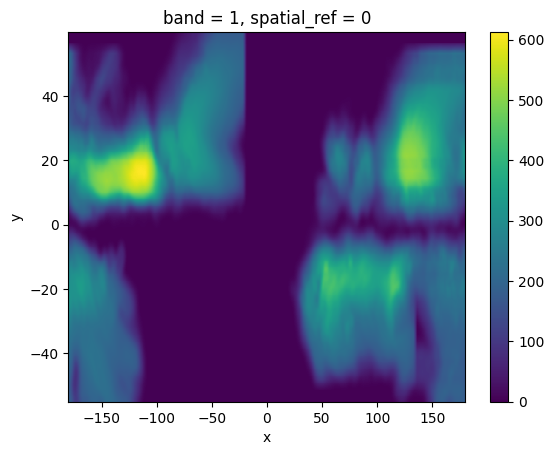

In [28]:
f.plot()
f.close()

#### Coastal flood hazard map
Worl Bank Data Catalog "Global Coastal Flood Hazard": https://datacatalog.worldbank.org/search/dataset/0038579/Global-coastal-flood-hazard \
Article: https://www.nature.com/articles/ncomms11969

In [ ]:
def dwnl_coastalhaz(rp):
    """
    Downloads coastal hazard raster maps from The World Bank Data Catalog service
    by providing the hazard return period
    
    rp: str
        Return period.
        Can be one of the following: 5yr, 10yr, 50yr, 100yr, 250yr, 500yr, 1000yr.

    Data source: https://datacatalog.worldbank.org/search/dataset/0038579/Global-coastal-flood-hazard
    """
    links = {
            "5yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/10/16/ss_muis_rp0005m.tif",
            "10yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/10/16/ss_muis_rp0010m.tif",
            "50yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/10/16/ss_muis_rp0050m.tif",
            "100yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/10/16/ss_muis_rp0100m.tif",
            "250yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/10/16/ss_muis_rp0250m.tif",
            "500yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/10/16/ss_muis_rp0500m.tif",
            "1000yr": "https://www.geonode-gfdrrlab.org/uploaded/layers/2019/10/16/ss_muis_rp1000m.tif",
            }
    tif = requests.get(links[rp])
    with open(f"data/impacts/coastalhaz_{rp}.tif", "wb") as tiffile:
            tiffile.write(tif.content)
            #need to compress the tif file when downloading it
            print("Download complete")

def load_coastalhaz(rp):
    """
    Loads coastal hazard raster maps downloaded through dwnl_coastalhaz
    by providing the return period
    
    rp: str
        Return period.
        Can be one of the following: 5yr, 10yr, 50yr, 100yr, 250yr, 500yr, 1000yr.
    """
    path = f"data/impacts/coastalhaz_{rp}.tif"
    f = rxr.open_rasterio(path)
    return(f)

In [ ]:
#Download the 1000yr coastal hazard raster map
dwnl_coastalhaz("1000yr")

Download complete


In [ ]:
#Load the 1000yr coastal hazard raster map
f = load_coastalhaz("1000yr")

print(f)
# f.plot()
#heavy to plot! 
#Unable to allocate 690. MiB for an array with shape (16744, 43200) and data type bool
#need to compress the file when downloading it or before plotting, making the user able
# to choose if compress it or not
f.close()

<xarray.DataArray (band: 1, y: 16744, x: 43200)>
[723340800 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 83.62 83.61 83.6 83.6 ... -55.88 -55.89 -55.9 -55.9
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    DataType:       Generic
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0


## Additional data

### Additional hazards
World Bank Global Tsunami Hazard: https://datacatalog.worldbank.org/search/dataset/0040783/Global-tsunami-hazard \
Global Flood Exposure by country: https://datacatalog.worldbank.org/search/dataset/0062763/Global-Flood-Exposure--Gridded-exposure-headcounts-by-country \
Global Earthquake Hazard: https://datacatalog.worldbank.org/search/dataset/0038576/Global-earthquake-hazard \
Global drought hazard: https://datacatalog.worldbank.org/search/dataset/0038582/Global-drought-hazard \

#### WWSI forecasted weather conditions (only in cities)
Guidelines on downloading forecast and climatological information from the WWIS website: https://worldweather.wmo.int/en/dataguide.html. By accessing "https://worldweather.wmo.int/en/json/[City ID]_en.json", the forecast for that city is provided for the next 5/7 days in a JSON format explained here: https://worldweather.wmo.int/en/json/WWIS_json_schema_v2.json. Below an example on retrieving forecasts

In [ ]:
#list of country codes
pd.read_csv("https://worldweather.wmo.int/en/json/full_city_list.txt", sep = ";").head()

,Country,City,CityId
0,Afghanistan,Herat,1183.0
1,Afghanistan,Kabul,219.0
2,Algeria,Algiers,242.0
3,Algeria,Annaba,1434.0
4,Algeria,Bechar,1435.0


In [ ]:
import json
from urllib.request import urlopen
response = urlopen("https://worldweather.wmo.int/en/json/242_en.json") #Algeri
data = json.load(response)
print(data)

{'city': {'lang': 'en', 'cityName': 'Algiers', 'cityLatitude': '36.700000000', 'cityLongitude': '3.220000000', 'cityId': 242, 'isCapital': True, 'stationName': 'Algiers', 'tourismURL': '', 'tourismBoardName': '', 'isDep': False, 'timeZone': '+0100', 'isDST': 'N', 'member': {'memId': 122, 'memName': 'Algeria', 'shortMemName': '', 'url': 'www.meteo.dz', 'orgName': 'National Meteorological Office', 'logo': 'algeria_logo.png', 'ra': 1}, 'forecast': {'issueDate': '2023-08-19 00:00:00', 'timeZone': 'Local', 'forecastDay': [{'forecastDate': '2023-08-20', 'wxdesc': '', 'weather': 'Sunny', 'minTemp': '22', 'maxTemp': '33', 'minTempF': '72', 'maxTempF': '91', 'weatherIcon': 2402}, {'forecastDate': '2023-08-21', 'wxdesc': '', 'weather': 'Sunny', 'minTemp': '21', 'maxTemp': '32', 'minTempF': '70', 'maxTempF': '90', 'weatherIcon': 2402}, {'forecastDate': '2023-08-22', 'wxdesc': '', 'weather': 'Sunny', 'minTemp': '22', 'maxTemp': '33', 'minTempF': '72', 'maxTempF': '91', 'weatherIcon': 2402}]}, 'cli